In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install pandas

In [ ]:
# import wrds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats.mstats import winsorize
import warnings
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings('ignore')

# Load Data

In [ ]:
# wrds.__version__
# db = wrds.Connection()

In [ ]:
# df_comp =  db.raw_sql("""
#       select fyear,
#       gvkey,
#       tic,
#       cik,
#       act,
#       lct,
#       che,
#       dlc,
#       dp,
#       at,
#       ib,
#       spi,
#       dvc,
#       txp,
#       csho,
#       ceq,
#       ivao,
#       lt,
#       dltt,
#       ivst,
#       pstk
#       from comp.funda
#       where fyear between '2009' and '2022'
# """)

In [ ]:
# df_comp.head()

In [ ]:
# df_comp.shape

In [ ]:
# df_comn = db.raw_sql("""
#
#     select conm,
#            gvkey,
#            sic
#            from comp.company
#
# """)

In [ ]:
# df_comn.head()

In [ ]:
# merged_df = pd.merge(df_comp, df_comn, on="gvkey", how="left")

In [ ]:
# merged_df.head()

In [ ]:
# merged_df.dtypes

In [ ]:
# merged_df['sic'] = merged_df['sic'].astype(int)

In [ ]:
# filtered_df = merged_df[~((merged_df['sic'] >= 4400) & (merged_df['sic'] <= 5000)) &
#                  ~((merged_df['sic'] >= 6000) & (merged_df['sic'] <= 6500))]

In [ ]:
# filtered_df.head()

In [ ]:
# filtered_df.drop_duplicates(subset=['gvkey', 'fyear'], inplace=True)
# filtered_df.head()

In [ ]:
def impute_with_avg_of_neighbors(df, column_names):
    """
    Imputes missing values in specified numerical columns of a DataFrame using the average of the
    next and previous year's values for each 'gvkey'.

    Parameters:
    - df: pandas DataFrame with the data.
    - column_names: list of strings, the names of the columns to impute.

    Returns:
    - DataFrame with imputed values in the specified columns.
    """
    # Sort the DataFrame by 'gvkey' and 'fyear' to ensure chronological order
    df = df.sort_values(by=['gvkey', 'fyear'])

    # Filter out non-numerical columns from the list
    numerical_columns = df[column_names].select_dtypes(include=[np.number]).columns.tolist()

    for column_name in numerical_columns:
        # Define temporary columns for forward fill and backward fill
        ffill_col = f'{column_name}_ffill'
        bfill_col = f'{column_name}_bfill'

        # Perform forward fill and backward fill within each 'gvkey' group
        df[ffill_col] = df.groupby('gvkey')[column_name].fillna(method='ffill')
        df[bfill_col] = df.groupby('gvkey')[column_name].fillna(method='bfill')

        # Calculate the average of the forward fill and backward fill values
        df[column_name] = df[column_name].fillna((df[ffill_col] + df[bfill_col]) / 2)

        # Drop the temporary columns
        df.drop(columns=[ffill_col, bfill_col], inplace=True)

    return df

In [ ]:
# variables_to_keep = [
#     'fyear', 'gvkey', 'tic', 'cik', 'act', 'lct', 'che', 'dlc', 'dp', 'at', 'ib',
#     'spi', 'dvc', 'txp', 'csho', 'ceq', 'ivao', 'lt', 'dltt', 'ivst', 'pstk', 'conm', 'sic'
# ]
#
# filtered_df = impute_with_avg_of_neighbors(filtered_df, variables_to_keep)
# print('finished imputing')

In [ ]:
# filtered_df.to_csv('full_dataset.csv', index=False)

In [ ]:
# schema = 'comp_na_daily_all'
# table = 'secm'
# data = db.get_table(schema, table, obs=5)
# print(data.columns)

In [ ]:
# data.head()

In [ ]:
# share_df = db.raw_sql("""
#     SELECT CSHOM,
#     PRCCM,
#     tic
#     FROM comp_na_daily_all.secm
#     WHERE datadate = '2019-06-30'
# """)
# share_df.head()

In [ ]:
# share_df.isna().sum()

In [ ]:
# share_df.shape

# Helper Functions

In [ ]:
def windsorize_fun(df,varlist):
    df_wind = df.copy()
    for var in varlist:
        df_wind[var] = df_wind[var].replace([np.inf, -np.inf], np.nan)
        df_wind[var] = df_wind.groupby('fyear')[var].transform(lambda x: winsorize(x, limits=(0.01, 0.01)))
    df_wind.dropna(subset=varlist, inplace=True)
    return df_wind

In [ ]:
def regress_with_intercept(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1
    X = sm.add_constant(X)
    if not X.empty:
        model = sm.OLS(Y, X, missing='drop').fit()
        # Get the adjusted R-squared value
        adjusted_r_squared = model.rsquared_adj
        print(model.summary())
        return model.params, adjusted_r_squared
    else:
        return None

In [ ]:
def regress_with_intercept(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1
    X = sm.add_constant(X)
    if not X.empty:
        model = sm.OLS(Y, X, missing='drop').fit()
        # Get the adjusted R-squared value
        adjusted_r_squared = model.rsquared_adj
        print(model.summary())
        return model.params, adjusted_r_squared
    else:
        return None


In [ ]:
def merging_data_coeff(data,coeff):
    for column in coeff.columns:
        data[column + '_coeff'] = coeff[column].iloc[0]
    return data

In [ ]:
def test_result(data,var,coeff,intercept):
    data['expected_earnings_in_years_tau'] = 0

    for var, coeff in zip(var, coeff):
        data['expected_earnings_in_years_tau'] += data[var] * data[coeff]

    data['expected_earnings_in_years_tau'] += data[intercept]

    return data

In [ ]:
def bias(data):
    data['residual'] = data['earnings_in_years_tau'] - data['expected_earnings_in_years_tau']
    data['market_value'] = data['cshom'] * data['prccm']/1000000
    data.dropna(subset=['market_value'], inplace = True)
    data = data[data['market_value'] != 0]
    data['bias'] = data['residual'] / data['market_value']
    return data

In [ ]:
def accuracy(data):
    data['accuracy'] = abs(data['bias'])
    return data

# Part 1

In [ ]:
#@title read data
filtered_df = pd.read_csv('/content/drive/MyDrive/RSM8224 Accounting/FINAL Project/full_dataset.csv')
share_df = pd.read_csv('/content/drive/MyDrive/RSM8224 Accounting/FINAL Project/share_df.csv')

In [ ]:
# Ensure the dataset is sorted by firm identifier and year
filtered_df = filtered_df.sort_values(by=['gvkey', 'fyear'])
# Create an industry category variable from the first two digits of the SIC code
filtered_df['industry'] = filtered_df['sic'].astype(str).str[:2]

#Encode industry based on its frequency
# Calculate the frequency
industry_freq = filtered_df['industry'].value_counts(normalize=True)
# Map the frequencies to the original 'industry' column
filtered_df['industry_freq'] = filtered_df['industry'].map(industry_freq)

In [ ]:
filtered_df.head()

,fyear,gvkey,tic,cik,act,lct,che,dlc,dp,at,...,ceq,ivao,lt,dltt,ivst,pstk,conm,sic,industry,industry_freq
0,2009,1004,AIR,1750.0,863.429,325.550,79.370,100.833,38.930,1501.042,...,746.906,2.143,754.692,336.191,0.0,0.0,AAR CORP,5080,50,0.010896
1,2010,1004,AIR,1750.0,913.985,416.010,57.433,114.075,59.296,1703.727,...,835.845,2.443,868.438,329.802,0.0,0.0,AAR CORP,5080,50,0.010896
2,2011,1004,AIR,1750.0,1063.272,473.226,67.720,122.865,80.333,2195.653,...,864.649,18.869,1329.631,669.489,0.0,0.0,AAR CORP,5080,50,0.010896
3,2012,1004,AIR,1750.0,1033.700,389.000,75.300,86.400,108.600,2136.900,...,918.600,16.800,1217.400,622.200,0.0,0.0,AAR CORP,5080,50,0.010896
4,2013,1004,AIR,1750.0,1116.900,402.100,89.200,69.700,113.400,2199.500,...,999.500,5.200,1198.800,564.300,0.0,0.0,AAR CORP,5080,50,0.010896


In [ ]:
actual_20 = filtered_df[filtered_df['fyear']==2020]

In [ ]:
actual_20.head()

,fyear,gvkey,tic,cik,act,lct,che,dlc,dp,at,...,ceq,ivao,lt,dltt,ivst,pstk,conm,sic,industry,industry_freq
11,2020,1004,AIR,1750.0,937.000,336.800,60.200,11.500,36.300,1539.700,...,974.400,29.9,565.300,193.600,8.400,0.0,AAR CORP,5080,50,0.010896
27,2020,1019,AFAP,2668.0,31.098,15.573,6.053,2.000,1.924,40.570,...,13.479,0.0,27.091,6.668,0.000,0.0,AFA PROTECTIVE SYSTEMS INC,7380,73,0.095180
39,2020,1050,CECO,3197.0,183.485,109.356,37.811,5.956,9.921,419.314,...,202.658,0.0,215.703,85.584,1.819,0.0,CECO ENVIRONMENTAL CORP,3564,35,0.026233
53,2020,1062,ASA,1230869.0,NaN,NaN,NaN,0.000,0.000,464.740,...,463.936,NaN,0.804,0.000,0.000,0.0,ASA GOLD AND PRECIOUS METALS,6799,67,0.331236
77,2020,1078,ABT,1800.0,20441.000,11907.000,7148.000,461.000,3327.000,72548.000,...,32784.000,178.0,39545.000,19429.000,310.000,0.0,ABBOTT LABORATORIES,3845,38,0.038103


In [ ]:
actual_22 = filtered_df[filtered_df['fyear']==2022]

In [ ]:
actual_22.head()

,fyear,gvkey,tic,cik,act,lct,che,dlc,dp,at,...,ceq,ivao,lt,dltt,ivst,pstk,conm,sic,industry,industry_freq
13,2022,1004,AIR,1750.0,1097.900,351.500,81.800,12.300,27.900,1833.100,...,1099.100,45.7,734.000,317.900,13.400,0.0,AAR CORP,5080,50,0.010896
41,2022,1050,CECO,3197.0,240.658,146.700,46.585,7.452,10.614,504.721,...,213.224,0.0,286.573,121.615,1.063,0.0,CECO ENVIRONMENTAL CORP,3564,35,0.026233
55,2022,1062,ASA,1230869.0,NaN,NaN,NaN,0.000,0.000,326.264,...,325.573,NaN,0.691,0.000,0.000,0.0,ASA GOLD AND PRECIOUS METALS,6799,67,0.331236
79,2022,1078,ABT,1800.0,25224.000,15489.000,10170.000,2481.000,3267.000,74438.000,...,36686.000,299.0,37533.000,15465.000,288.000,0.0,ABBOTT LABORATORIES,3845,38,0.038103
95,2022,1084,WDDD,1961.0,0.008,3.232,0.008,0.773,0.000,0.008,...,-3.224,0.0,3.232,0.000,0.000,0.0,WORLDS INC,7370,73,0.095180


In [ ]:
share_df.head()

,cshom,prccm,tic
0,35067000.0,36.790,AIR
1,193000.0,199.000,AFAP
2,36000.0,0.715,IWKS
3,444835000.0,32.610,AAL
4,35052000.0,9.590,CECO


In [ ]:
def hvz(filtered_df,step):
    new_filtered_df = filtered_df.copy()
    new_filtered_df.sort_values(by=['gvkey', 'fyear'], inplace=True)
    new_filtered_df['earnings_in_years_t'] = new_filtered_df['ib'] - new_filtered_df['spi']
    new_filtered_df['DD'] = new_filtered_df['dvc'].notna().astype(int)
    new_filtered_df['NegE'] = np.where(new_filtered_df['earnings_in_years_t'] < 0, 1, 0)
    new_filtered_df['non_cash_current_asset'] = new_filtered_df['act'] - new_filtered_df['che']
    new_filtered_df['current_liability_wo_debt_tax'] = new_filtered_df['lct'] - new_filtered_df['dlc'] - new_filtered_df['txp']
    new_filtered_df['delta_non_cash_current_asset'] = new_filtered_df['non_cash_current_asset'] - new_filtered_df.groupby('gvkey')['non_cash_current_asset'].shift(1)
    new_filtered_df['delta_current_liability_wo_debt_tax'] = new_filtered_df['current_liability_wo_debt_tax'] - new_filtered_df.groupby('gvkey')['current_liability_wo_debt_tax'].shift(1)
    new_filtered_df['AC'] = new_filtered_df['delta_non_cash_current_asset'] - new_filtered_df['delta_current_liability_wo_debt_tax'] - new_filtered_df['dp']
    new_filtered_df['earnings_in_years_tau'] = new_filtered_df.groupby('gvkey')['earnings_in_years_t'].shift(-(step))
    new_filtered_df.dropna(subset=['earnings_in_years_t','DD','NegE','AC','earnings_in_years_tau'], inplace = True)
    return new_filtered_df

In [ ]:
def hvz_model(data,step):
    temp_df = hvz(data,step)

    train_df = temp_df[(temp_df['fyear'] >= 2009) & (temp_df['fyear'] <= 2019)].copy()
    test_df = temp_df[(temp_df['fyear'] >= 2019) & (temp_df['fyear'] <= 2022)].copy()

    varlist = ['earnings_in_years_t','at','dvc','DD','NegE','AC','earnings_in_years_tau']
    hvz_winsorized_df = windsorize_fun(train_df,varlist)

    coeff, adjusted_r_squared = regress_with_intercept(hvz_winsorized_df, 'earnings_in_years_tau', ['earnings_in_years_t','at','dvc','DD','NegE','AC'])
    df_final = pd.DataFrame([coeff])
    df_return = merging_data_coeff(test_df,df_final)

    coeff_model = ['earnings_in_years_t_coeff','at_coeff','dvc_coeff','DD_coeff','NegE_coeff','AC_coeff']
    values = ['earnings_in_years_t','at','dvc','DD','NegE','AC']
    intercept_col = 'intercept_coeff'

    model_results = test_result(df_return,values,coeff_model,intercept_col)
    print('adjust_r_squared is: ', adjusted_r_squared)
    return model_results

In [ ]:
print('hvz_df_2020')
hvz_df_2020 = hvz_model(filtered_df,1)
print('hvz_df_2021')
hvz_df_2021 = hvz_model(filtered_df,2)
print('hvz_df_2022')
hvz_df_2022 = hvz_model(filtered_df,3)

hvz_df_2020
                              OLS Regression Results                             
Dep. Variable:     earnings_in_years_tau   R-squared:                       0.829
Model:                               OLS   Adj. R-squared:                  0.829
Method:                    Least Squares   F-statistic:                 5.030e+04
Date:                   Thu, 25 Apr 2024   Prob (F-statistic):               0.00
Time:                           15:07:15   Log-Likelihood:            -3.7350e+05
No. Observations:                  52027   AIC:                         7.470e+05
Df Residuals:                      52021   BIC:                         7.471e+05
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [ ]:
hvz_df_2020 = pd.merge(hvz_df_2020, share_df, on="tic", how="left")

In [ ]:
hvz_df_2020 = hvz_df_2020[hvz_df_2020['fyear'] == 2019]
hvz_df_2020.head()

,fyear,gvkey,tic,cik,act,lct,che,dlc,dp,at,...,earnings_in_years_t_coeff,at_coeff,dvc_coeff,DD_coeff,NegE_coeff,AC_coeff,intercept_coeff,expected_earnings_in_years_tau,cshom,prccm
0,2019,1004,AIR,1750.0,1438.700,383.100,424.700,13.700,43.700,2079.000,...,0.778259,0.01309,0.043205,1.771942,-4.966232,0.08104,1.771942,103.515744,3.506700e+07,36.7900
3,2019,1050,CECO,3197.0,179.498,115.188,36.958,5.626,10.609,408.637,...,0.778259,0.01309,0.043205,1.771942,-4.966232,0.08104,1.771942,24.727985,3.505200e+07,9.5900
6,2019,1078,ABT,1800.0,15667.000,10863.000,4140.000,1683.000,3014.000,67887.000,...,0.778259,0.01309,0.043205,1.771942,-4.966232,0.08104,1.771942,4118.138423,1.764181e+09,84.1000
9,2019,1084,WDDD,1961.0,1.571,3.219,1.571,0.773,0.000,1.774,...,0.778259,0.01309,0.043205,1.771942,-4.966232,0.08104,1.771942,-2.321247,5.681500e+07,0.2801
12,2019,1096,MRCBF,NaN,222.852,1160.841,123.168,919.871,36.152,11703.084,...,0.778259,0.01309,0.043205,1.771942,-4.966232,0.08104,1.771942,299.982983,NaN,145.0560


In [ ]:
hvz_df_2020['residual'] = hvz_df_2020['earnings_in_years_tau'] - hvz_df_2020['expected_earnings_in_years_tau']
hvz_df_2020.head()

,fyear,gvkey,tic,cik,act,lct,che,dlc,dp,at,...,at_coeff,dvc_coeff,DD_coeff,NegE_coeff,AC_coeff,intercept_coeff,expected_earnings_in_years_tau,cshom,prccm,residual
0,2019,1004,AIR,1750.0,1438.700,383.100,424.700,13.700,43.700,2079.000,...,0.01309,0.043205,1.771942,-4.966232,0.08104,1.771942,103.515744,3.506700e+07,36.7900,-73.315744
3,2019,1050,CECO,3197.0,179.498,115.188,36.958,5.626,10.609,408.637,...,0.01309,0.043205,1.771942,-4.966232,0.08104,1.771942,24.727985,3.505200e+07,9.5900,-9.269985
6,2019,1078,ABT,1800.0,15667.000,10863.000,4140.000,1683.000,3014.000,67887.000,...,0.01309,0.043205,1.771942,-4.966232,0.08104,1.771942,4118.138423,1.764181e+09,84.1000,819.861577
9,2019,1084,WDDD,1961.0,1.571,3.219,1.571,0.773,0.000,1.774,...,0.01309,0.043205,1.771942,-4.966232,0.08104,1.771942,-2.321247,5.681500e+07,0.2801,0.752247
12,2019,1096,MRCBF,NaN,222.852,1160.841,123.168,919.871,36.152,11703.084,...,0.01309,0.043205,1.771942,-4.966232,0.08104,1.771942,299.982983,NaN,145.0560,-423.403983


In [ ]:
hvz_df_2021 = pd.merge(hvz_df_2021, share_df, on="tic", how="left")

In [ ]:
hvz_df_2021 = hvz_df_2021[hvz_df_2021['fyear'] == 2019]
hvz_df_2021.head()

,fyear,gvkey,tic,cik,act,lct,che,dlc,dp,at,...,earnings_in_years_t_coeff,at_coeff,dvc_coeff,DD_coeff,NegE_coeff,AC_coeff,intercept_coeff,expected_earnings_in_years_tau,cshom,prccm
0,2019,1004,AIR,1750.0,1438.700,383.100,424.700,13.700,43.700,2079.000,...,0.650807,0.0164,0.104474,2.66246,-8.022177,-0.059503,2.66246,95.013754,3.506700e+07,36.7900
2,2019,1050,CECO,3197.0,179.498,115.188,36.958,5.626,10.609,408.637,...,0.650807,0.0164,0.104474,2.66246,-8.022177,-0.059503,2.66246,24.525719,3.505200e+07,9.5900
4,2019,1078,ABT,1800.0,15667.000,10863.000,4140.000,1683.000,3014.000,67887.000,...,0.650807,0.0164,0.104474,2.66246,-8.022177,-0.059503,2.66246,4293.017576,1.764181e+09,84.1000
6,2019,1084,WDDD,1961.0,1.571,3.219,1.571,0.773,0.000,1.774,...,0.650807,0.0164,0.104474,2.66246,-8.022177,-0.059503,2.66246,-3.499344,5.681500e+07,0.2801
8,2019,1096,MRCBF,NaN,222.852,1160.841,123.168,919.871,36.152,11703.084,...,0.650807,0.0164,0.104474,2.66246,-8.022177,-0.059503,2.66246,322.174724,NaN,145.0560


In [ ]:
hvz_df_2022 = pd.merge(hvz_df_2022, share_df, on="tic", how="left")

In [ ]:
hvz_df_2022 = hvz_df_2022[hvz_df_2022['fyear'] == 2019]
hvz_df_2022.head()

,fyear,gvkey,tic,cik,act,lct,che,dlc,dp,at,...,earnings_in_years_t_coeff,at_coeff,dvc_coeff,DD_coeff,NegE_coeff,AC_coeff,intercept_coeff,expected_earnings_in_years_tau,cshom,prccm
0,2019,1004,AIR,1750.0,1438.700,383.100,424.700,13.700,43.700,2079.000,...,0.628783,0.020019,0.119809,7.083536,-16.904042,-0.073677,7.083536,108.939329,3.506700e+07,36.7900
1,2019,1050,CECO,3197.0,179.498,115.188,36.958,5.626,10.609,408.637,...,0.628783,0.020019,0.119809,7.083536,-16.904042,-0.073677,7.083536,34.329213,3.505200e+07,9.5900
2,2019,1078,ABT,1800.0,15667.000,10863.000,4140.000,1683.000,3014.000,67887.000,...,0.628783,0.020019,0.119809,7.083536,-16.904042,-0.073677,7.083536,4524.586431,1.764181e+09,84.1000
3,2019,1084,WDDD,1961.0,1.571,3.219,1.571,0.773,0.000,1.774,...,0.628783,0.020019,0.119809,7.083536,-16.904042,-0.073677,7.083536,-3.512149,5.681500e+07,0.2801
4,2019,1096,MRCBF,NaN,222.852,1160.841,123.168,919.871,36.152,11703.084,...,0.628783,0.020019,0.119809,7.083536,-16.904042,-0.073677,7.083536,369.862597,NaN,145.0560


In [ ]:
hvz_df_2020 = bias(hvz_df_2020)
hvz_df_2020 = accuracy(hvz_df_2020)
hvz_df_2020.head()

,fyear,gvkey,tic,cik,act,lct,che,dlc,dp,at,...,NegE_coeff,AC_coeff,intercept_coeff,expected_earnings_in_years_tau,cshom,prccm,residual,market_value,bias,accuracy
0,2019,1004,AIR,1750.0,1438.700,383.100,424.700,13.700,43.700,2079.000,...,-4.966232,0.08104,1.771942,103.515744,3.506700e+07,36.7900,-73.315744,1290.114930,-0.056829,0.056829
3,2019,1050,CECO,3197.0,179.498,115.188,36.958,5.626,10.609,408.637,...,-4.966232,0.08104,1.771942,24.727985,3.505200e+07,9.5900,-9.269985,336.148680,-0.027577,0.027577
6,2019,1078,ABT,1800.0,15667.000,10863.000,4140.000,1683.000,3014.000,67887.000,...,-4.966232,0.08104,1.771942,4118.138423,1.764181e+09,84.1000,819.861577,148367.622100,0.005526,0.005526
9,2019,1084,WDDD,1961.0,1.571,3.219,1.571,0.773,0.000,1.774,...,-4.966232,0.08104,1.771942,-2.321247,5.681500e+07,0.2801,0.752247,15.913882,0.047270,0.047270
15,2019,1104,ACU,2098.0,73.146,16.583,6.822,1.314,3.433,110.749,...,-4.966232,0.08104,1.771942,8.717282,3.352000e+06,22.5800,-0.618282,75.688160,-0.008169,0.008169


In [ ]:
hvz_df_2021 = bias(hvz_df_2021)
hvz_df_2021 = accuracy(hvz_df_2021)
hvz_df_2021.head()

,fyear,gvkey,tic,cik,act,lct,che,dlc,dp,at,...,NegE_coeff,AC_coeff,intercept_coeff,expected_earnings_in_years_tau,cshom,prccm,residual,market_value,bias,accuracy
0,2019,1004,AIR,1750.0,1438.700,383.100,424.700,13.700,43.700,2079.000,...,-8.022177,-0.059503,2.66246,95.013754,3.506700e+07,36.7900,-10.113754,1290.114930,-0.007839,0.007839
2,2019,1050,CECO,3197.0,179.498,115.188,36.958,5.626,10.609,408.637,...,-8.022177,-0.059503,2.66246,24.525719,3.505200e+07,9.5900,-20.916719,336.148680,-0.062225,0.062225
4,2019,1078,ABT,1800.0,15667.000,10863.000,4140.000,1683.000,3014.000,67887.000,...,-8.022177,-0.059503,2.66246,4293.017576,1.764181e+09,84.1000,3316.982424,148367.622100,0.022357,0.022357
6,2019,1084,WDDD,1961.0,1.571,3.219,1.571,0.773,0.000,1.774,...,-8.022177,-0.059503,2.66246,-3.499344,5.681500e+07,0.2801,2.579344,15.913882,0.162081,0.162081
10,2019,1104,ACU,2098.0,73.146,16.583,6.822,1.314,3.433,110.749,...,-8.022177,-0.059503,2.66246,11.365981,3.352000e+06,22.5800,-1.217981,75.688160,-0.016092,0.016092


In [ ]:
hvz_df_2022 = bias(hvz_df_2022)
hvz_df_2022 = accuracy(hvz_df_2022)
hvz_df_2022.head()

,fyear,gvkey,tic,cik,act,lct,che,dlc,dp,at,...,NegE_coeff,AC_coeff,intercept_coeff,expected_earnings_in_years_tau,cshom,prccm,residual,market_value,bias,accuracy
0,2019,1004,AIR,1750.0,1438.700,383.100,424.700,13.700,43.700,2079.000,...,-16.904042,-0.073677,7.083536,108.939329,3.506700e+07,36.7900,-4.839329,1290.114930,-0.003751,0.003751
1,2019,1050,CECO,3197.0,179.498,115.188,36.958,5.626,10.609,408.637,...,-16.904042,-0.073677,7.083536,34.329213,3.505200e+07,9.5900,-13.859213,336.148680,-0.041229,0.041229
2,2019,1078,ABT,1800.0,15667.000,10863.000,4140.000,1683.000,3014.000,67887.000,...,-16.904042,-0.073677,7.083536,4524.586431,1.764181e+09,84.1000,3149.413569,148367.622100,0.021227,0.021227
3,2019,1084,WDDD,1961.0,1.571,3.219,1.571,0.773,0.000,1.774,...,-16.904042,-0.073677,7.083536,-3.512149,5.681500e+07,0.2801,2.726149,15.913882,0.171306,0.171306
5,2019,1104,ACU,2098.0,73.146,16.583,6.822,1.314,3.433,110.749,...,-16.904042,-0.073677,7.083536,20.623642,3.352000e+06,22.5800,-17.588642,75.688160,-0.232383,0.232383


In [ ]:
def ep(filtered_df,step):
    new_filtered_df = filtered_df.copy()
    new_filtered_df.sort_values(by=['gvkey', 'fyear'], inplace=True)

    new_filtered_df['earning'] = new_filtered_df['ib'] - new_filtered_df['spi']
    new_filtered_df['earnings_in_years_tau_num'] = new_filtered_df.groupby('gvkey')['earning'].shift(-(step))
    new_filtered_df = new_filtered_df[(new_filtered_df['csho'] != 0)]
    new_filtered_df['earnings_in_years_tau'] = new_filtered_df['earnings_in_years_tau_num'] / new_filtered_df['csho']
    new_filtered_df['NegE'] = np.where(new_filtered_df['earning'] < 0, 1, 0)
    new_filtered_df['NegE_earnings_in_years_t_interaction'] = new_filtered_df['NegE'] * new_filtered_df['earning']
    new_filtered_df.dropna(subset=['earning','NegE','NegE_earnings_in_years_t_interaction','earnings_in_years_tau'], inplace = True)
    return new_filtered_df

In [ ]:
def ep_model(data,step):
    temp_df = ep(data,step)

    train_df = temp_df[(temp_df['fyear'] >= 2009) & (temp_df['fyear'] <= 2019)].copy()
    test_df = temp_df[(temp_df['fyear'] >= 2019) & (temp_df['fyear'] <= 2022)].copy()

    varlist = ['earning','NegE','NegE_earnings_in_years_t_interaction','earnings_in_years_tau']
    ep_winsorized_df = windsorize_fun(train_df,varlist)

    coeff, adjusted_r_squared = regress_with_intercept(ep_winsorized_df, 'earnings_in_years_tau', ['earning','NegE','NegE_earnings_in_years_t_interaction'])
    df_final = pd.DataFrame([coeff])
    df_return = merging_data_coeff(test_df,df_final)

    coeff_model = ['earning_coeff','NegE_coeff','NegE_earnings_in_years_t_interaction_coeff']
    values = ['earning','NegE','NegE_earnings_in_years_t_interaction']
    intercept_col = 'intercept_coeff'

    model_results = test_result(df_return,values,coeff_model,intercept_col)
    print('adjust_r_squared is: ', adjusted_r_squared)
    return model_results

In [ ]:
print('ep_df_2020')
ep_df_2020 = ep_model(filtered_df,1)
print('ep_df_2021')
ep_df_2021 = ep_model(filtered_df,2)
print('ep_df_2022')
ep_df_2022 = ep_model(filtered_df,3)

ep_df_2020
                              OLS Regression Results                             
Dep. Variable:     earnings_in_years_tau   R-squared:                       0.154
Model:                               OLS   Adj. R-squared:                  0.154
Method:                    Least Squares   F-statistic:                     3882.
Date:                   Thu, 25 Apr 2024   Prob (F-statistic):               0.00
Time:                           15:07:17   Log-Likelihood:            -1.7573e+05
No. Observations:                  63757   AIC:                         3.515e+05
Df Residuals:                      63753   BIC:                         3.515e+05
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

In [ ]:
ep_df_2020 = pd.merge(ep_df_2020, share_df, on="tic", how="left")
ep_df_2020 = ep_df_2020[ep_df_2020['fyear'] == 2019]
ep_df_2020.head()

,fyear,gvkey,tic,cik,act,lct,che,dlc,dp,at,...,earnings_in_years_tau,NegE,NegE_earnings_in_years_t_interaction,earning_coeff,NegE_coeff,NegE_earnings_in_years_t_interaction_coeff,intercept_coeff,expected_earnings_in_years_tau,cshom,prccm
0,2019,1004,AIR,1750.0,1438.700,383.100,424.700,13.700,43.700,2079.000,...,0.860472,0,0.000,0.000964,-2.457306,0.003265,1.515252,1.600072,3.506700e+07,36.7900
3,2019,1019,AFAP,2668.0,23.727,16.881,1.865,1.833,1.981,33.355,...,16.067901,0,0.000,0.000964,-2.457306,0.003265,1.515252,1.517373,1.930000e+05,199.0000
4,2019,1050,CECO,3197.0,179.498,115.188,36.958,5.626,10.609,408.637,...,0.439935,0,0.000,0.000964,-2.457306,0.003265,1.515252,1.534278,3.505200e+07,9.5900
7,2019,1078,ABT,1800.0,15667.000,10863.000,4140.000,1683.000,3014.000,67887.000,...,2.801697,0,0.000,0.000964,-2.457306,0.003265,1.515252,5.634820,1.764181e+09,84.1000
10,2019,1084,WDDD,1961.0,1.571,3.219,1.571,0.773,0.000,1.774,...,-0.027616,1,-1.234,0.000964,-2.457306,0.003265,1.515252,-0.947272,5.681500e+07,0.2801


In [ ]:
ep_df_2021 = pd.merge(ep_df_2021, share_df, on="tic", how="left")

In [ ]:
ep_df_2021 = ep_df_2021[ep_df_2021['fyear'] == 2019]
ep_df_2021.head()

,fyear,gvkey,tic,cik,act,lct,che,dlc,dp,at,...,earnings_in_years_tau,NegE,NegE_earnings_in_years_t_interaction,earning_coeff,NegE_coeff,NegE_earnings_in_years_t_interaction_coeff,intercept_coeff,expected_earnings_in_years_tau,cshom,prccm
0,2019,1004,AIR,1750.0,1438.700,383.100,424.700,13.700,43.700,2079.000,...,2.419010,0,0.000,0.000939,-2.920065,-0.000071,1.601071,1.683705,3.506700e+07,36.7900
2,2019,1050,CECO,3197.0,179.498,115.188,36.958,5.626,10.609,408.637,...,0.102712,0,0.000,0.000939,-2.920065,-0.000071,1.601071,1.619607,3.505200e+07,9.5900
4,2019,1078,ABT,1800.0,15667.000,10863.000,4140.000,1683.000,3014.000,67887.000,...,4.317723,0,0.000,0.000939,-2.920065,-0.000071,1.601071,5.614444,1.764181e+09,84.1000
6,2019,1084,WDDD,1961.0,1.571,3.219,1.571,0.773,0.000,1.774,...,-0.016193,1,-1.234,0.000939,-2.920065,-0.000071,1.601071,-1.320064,5.681500e+07,0.2801
8,2019,1096,MRCBF,NaN,222.852,1160.841,123.168,919.871,36.152,11703.084,...,20.498272,0,0.000,0.000939,-2.920065,-0.000071,1.601071,1.777138,NaN,145.0560


In [ ]:
ep_df_2022 = pd.merge(ep_df_2022, share_df, on="tic", how="left")

In [ ]:
ep_df_2022 = ep_df_2022[ep_df_2022['fyear'] == 2019]
ep_df_2022.head()

,fyear,gvkey,tic,cik,act,lct,che,dlc,dp,at,...,earnings_in_years_tau,NegE,NegE_earnings_in_years_t_interaction,earning_coeff,NegE_coeff,NegE_earnings_in_years_t_interaction_coeff,intercept_coeff,expected_earnings_in_years_tau,cshom,prccm
0,2019,1004,AIR,1750.0,1438.700,383.100,424.700,13.700,43.700,2079.000,...,2.966065,0,0.000,0.000932,-3.511243,-0.001413,1.721282,1.803327,3.506700e+07,36.7900
1,2019,1050,CECO,3197.0,179.498,115.188,36.958,5.626,10.609,408.637,...,0.582577,0,0.000,0.000932,-3.511243,-0.001413,1.721282,1.739685,3.505200e+07,9.5900
2,2019,1078,ABT,1800.0,15667.000,10863.000,4140.000,1683.000,3014.000,67887.000,...,4.354035,0,0.000,0.000932,-3.511243,-0.001413,1.721282,5.706063,1.764181e+09,84.1000
3,2019,1084,WDDD,1961.0,1.571,3.219,1.571,0.773,0.000,1.774,...,-0.013834,1,-1.234,0.000932,-3.511243,-0.001413,1.721282,-1.789369,5.681500e+07,0.2801
4,2019,1096,MRCBF,NaN,222.852,1160.841,123.168,919.871,36.152,11703.084,...,10.778162,0,0.000,0.000932,-3.511243,-0.001413,1.721282,1.896094,NaN,145.0560


In [ ]:
ep_df_2020 = bias(ep_df_2020)
ep_df_2020 = accuracy(ep_df_2020)
ep_df_2020.head()

,fyear,gvkey,tic,cik,act,lct,che,dlc,dp,at,...,NegE_coeff,NegE_earnings_in_years_t_interaction_coeff,intercept_coeff,expected_earnings_in_years_tau,cshom,prccm,residual,market_value,bias,accuracy
0,2019,1004,AIR,1750.0,1438.700,383.100,424.700,13.700,43.700,2079.000,...,-2.457306,0.003265,1.515252,1.600072,3.506700e+07,36.7900,-0.739600,1290.114930,-0.000573,0.000573
3,2019,1019,AFAP,2668.0,23.727,16.881,1.865,1.833,1.981,33.355,...,-2.457306,0.003265,1.515252,1.517373,1.930000e+05,199.0000,14.550528,38.407000,0.378851,0.378851
4,2019,1050,CECO,3197.0,179.498,115.188,36.958,5.626,10.609,408.637,...,-2.457306,0.003265,1.515252,1.534278,3.505200e+07,9.5900,-1.094342,336.148680,-0.003256,0.003256
7,2019,1078,ABT,1800.0,15667.000,10863.000,4140.000,1683.000,3014.000,67887.000,...,-2.457306,0.003265,1.515252,5.634820,1.764181e+09,84.1000,-2.833122,148367.622100,-0.000019,0.000019
10,2019,1084,WDDD,1961.0,1.571,3.219,1.571,0.773,0.000,1.774,...,-2.457306,0.003265,1.515252,-0.947272,5.681500e+07,0.2801,0.919656,15.913882,0.057790,0.057790


In [ ]:
ep_df_2021 = bias(ep_df_2021)
ep_df_2021 = accuracy(ep_df_2021)
ep_df_2021.head()

,fyear,gvkey,tic,cik,act,lct,che,dlc,dp,at,...,NegE_coeff,NegE_earnings_in_years_t_interaction_coeff,intercept_coeff,expected_earnings_in_years_tau,cshom,prccm,residual,market_value,bias,accuracy
0,2019,1004,AIR,1750.0,1438.700,383.100,424.700,13.700,43.700,2079.000,...,-2.920065,-0.000071,1.601071,1.683705,3.506700e+07,36.7900,0.735305,1290.114930,0.000570,0.000570
2,2019,1050,CECO,3197.0,179.498,115.188,36.958,5.626,10.609,408.637,...,-2.920065,-0.000071,1.601071,1.619607,3.505200e+07,9.5900,-1.516894,336.148680,-0.004513,0.004513
4,2019,1078,ABT,1800.0,15667.000,10863.000,4140.000,1683.000,3014.000,67887.000,...,-2.920065,-0.000071,1.601071,5.614444,1.764181e+09,84.1000,-1.296721,148367.622100,-0.000009,0.000009
6,2019,1084,WDDD,1961.0,1.571,3.219,1.571,0.773,0.000,1.774,...,-2.920065,-0.000071,1.601071,-1.320064,5.681500e+07,0.2801,1.303871,15.913882,0.081933,0.081933
10,2019,1104,ACU,2098.0,73.146,16.583,6.822,1.314,3.433,110.749,...,-2.920065,-0.000071,1.601071,1.606249,3.352000e+06,22.5800,1.422101,75.688160,0.018789,0.018789


In [ ]:
ep_df_2022 = bias(ep_df_2022)
ep_df_2022 = accuracy(ep_df_2022)
ep_df_2022.head()

,fyear,gvkey,tic,cik,act,lct,che,dlc,dp,at,...,NegE_coeff,NegE_earnings_in_years_t_interaction_coeff,intercept_coeff,expected_earnings_in_years_tau,cshom,prccm,residual,market_value,bias,accuracy
0,2019,1004,AIR,1750.0,1438.700,383.100,424.700,13.700,43.700,2079.000,...,-3.511243,-0.001413,1.721282,1.803327,3.506700e+07,36.7900,1.162739,1290.114930,0.000901,0.000901
1,2019,1050,CECO,3197.0,179.498,115.188,36.958,5.626,10.609,408.637,...,-3.511243,-0.001413,1.721282,1.739685,3.505200e+07,9.5900,-1.157108,336.148680,-0.003442,0.003442
2,2019,1078,ABT,1800.0,15667.000,10863.000,4140.000,1683.000,3014.000,67887.000,...,-3.511243,-0.001413,1.721282,5.706063,1.764181e+09,84.1000,-1.352028,148367.622100,-0.000009,0.000009
3,2019,1084,WDDD,1961.0,1.571,3.219,1.571,0.773,0.000,1.774,...,-3.511243,-0.001413,1.721282,-1.789369,5.681500e+07,0.2801,1.775534,15.913882,0.111571,0.111571
5,2019,1104,ACU,2098.0,73.146,16.583,6.822,1.314,3.433,110.749,...,-3.511243,-0.001413,1.721282,1.726423,3.352000e+06,22.5800,-0.820723,75.688160,-0.010843,0.010843


In [ ]:
def ri(filtered_df,step):
    new_filtered_df = filtered_df.copy()
    new_filtered_df.sort_values(by=['gvkey', 'fyear'], inplace=True)

    new_filtered_df['earning'] = new_filtered_df['ib'] - new_filtered_df['spi']
    new_filtered_df = new_filtered_df[(new_filtered_df['csho'] != 0)]
    new_filtered_df['earnings_in_years_tau'] = new_filtered_df.groupby('gvkey')['earning'].shift((-step)) / new_filtered_df['csho']
    new_filtered_df['NegE'] = np.where(new_filtered_df['earning'] < 0, 1, 0)
    new_filtered_df['NegE_earnings_in_years_t_interaction'] = new_filtered_df['NegE'] * new_filtered_df['earning']
    new_filtered_df['B'] = new_filtered_df['ceq'] / new_filtered_df['csho']

    new_filtered_df['WC'] = (new_filtered_df['act'] - new_filtered_df['che']) - (new_filtered_df['lct'] - new_filtered_df['dlc'])
    new_filtered_df['NCO'] = (new_filtered_df['at'] - new_filtered_df['act'] - new_filtered_df['ivao']) - (new_filtered_df['lt'] - new_filtered_df['lct'] - new_filtered_df['dltt'])
    new_filtered_df['FIN'] = (new_filtered_df['ivst'] + new_filtered_df['ivao']) - (new_filtered_df['dltt'] + new_filtered_df['dlc'] + new_filtered_df['pstk'])
    new_filtered_df['TACC'] = (new_filtered_df['WC'] + new_filtered_df['NCO'] + new_filtered_df['FIN'])/new_filtered_df['csho']

    new_filtered_df.dropna(subset=['earning','NegE','NegE_earnings_in_years_t_interaction','earnings_in_years_tau','B'], inplace = True)
    new_filtered_df['TACC'] = new_filtered_df['TACC'].replace(np.nan, 0)
    return new_filtered_df

In [ ]:
def ri_model(data,step):
    temp_df = ri(data,step)

    train_df = temp_df[(temp_df['fyear'] >= 2009) & (temp_df['fyear'] <= 2019)].copy()
    test_df = temp_df[(temp_df['fyear'] >= 2019) & (temp_df['fyear'] <= 2022)].copy()

    varlist = ['earning','NegE','NegE_earnings_in_years_t_interaction','B','TACC','earnings_in_years_tau']
    ri_winsorized_df = windsorize_fun(train_df,varlist)

    coeff, adjusted_r_squared = regress_with_intercept(ri_winsorized_df, 'earnings_in_years_tau', ['earning','NegE','NegE_earnings_in_years_t_interaction','B','TACC'])
    df_final = pd.DataFrame([coeff])
    df_return = merging_data_coeff(test_df,df_final)

    coeff_model = ['earning_coeff','NegE_coeff','NegE_earnings_in_years_t_interaction_coeff','B_coeff','TACC_coeff']
    values = ['earning','NegE','NegE_earnings_in_years_t_interaction','B','TACC']
    intercept_col = 'intercept_coeff'

    model_results = test_result(df_return,values,coeff_model,intercept_col)
    print('adjust_r_squared is: ', adjusted_r_squared)
    return model_results

In [ ]:
print('ri_df_2020')
ri_df_2020 = ri_model(filtered_df,1)
print('ri_df_2021')
ri_df_2021 = ri_model(filtered_df,2)
print('ri_df_2022')
ri_df_2022 = ri_model(filtered_df,3)

ri_df_2020
                              OLS Regression Results                             
Dep. Variable:     earnings_in_years_tau   R-squared:                       0.335
Model:                               OLS   Adj. R-squared:                  0.335
Method:                    Least Squares   F-statistic:                     6423.
Date:                   Thu, 25 Apr 2024   Prob (F-statistic):               0.00
Time:                           15:07:19   Log-Likelihood:            -1.6753e+05
No. Observations:                  63686   AIC:                         3.351e+05
Df Residuals:                      63680   BIC:                         3.351e+05
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

In [ ]:
ri_df_2020 = pd.merge(ri_df_2020, share_df, on="tic", how="left")
ri_df_2020 = ri_df_2020[ri_df_2020['fyear'] == 2019]
ri_df_2020.head()

,fyear,gvkey,tic,cik,act,lct,che,dlc,dp,at,...,TACC,earning_coeff,NegE_coeff,NegE_earnings_in_years_t_interaction_coeff,B_coeff,TACC_coeff,intercept_coeff,expected_earnings_in_years_tau,cshom,prccm
0,2019,1004,AIR,1750.0,1438.700,383.100,424.700,13.700,43.700,2079.000,...,14.186398,0.000498,-1.226126,0.00515,0.046336,0.090656,0.313658,2.835224,3.506700e+07,36.7900
3,2019,1019,AFAP,2668.0,23.727,16.881,1.865,1.833,1.981,33.355,...,60.296296,0.000498,-1.226126,0.00515,0.046336,0.090656,0.313658,9.108328,1.930000e+05,199.0000
4,2019,1050,CECO,3197.0,179.498,115.188,36.958,5.626,10.609,408.637,...,4.480035,0.000498,-1.226126,0.00515,0.046336,0.090656,0.313658,0.984171,3.505200e+07,9.5900
7,2019,1078,ABT,1800.0,15667.000,10863.000,4140.000,1683.000,3014.000,67887.000,...,15.569335,0.000498,-1.226126,0.00515,0.046336,0.090656,0.313658,4.671478,1.764181e+09,84.1000
10,2019,1084,WDDD,1961.0,1.571,3.219,1.571,0.773,0.000,1.774,...,-0.053085,0.000498,-1.226126,0.00515,0.046336,0.090656,0.313658,-0.925428,5.681500e+07,0.2801


In [ ]:
ri_df_2021 = pd.merge(ri_df_2021, share_df, on="tic", how="left")
ri_df_2021 = ri_df_2021[ri_df_2021['fyear'] == 2019]
ri_df_2021.head()

,fyear,gvkey,tic,cik,act,lct,che,dlc,dp,at,...,TACC,earning_coeff,NegE_coeff,NegE_earnings_in_years_t_interaction_coeff,B_coeff,TACC_coeff,intercept_coeff,expected_earnings_in_years_tau,cshom,prccm
0,2019,1004,AIR,1750.0,1438.700,383.100,424.700,13.700,43.700,2079.000,...,14.186398,0.000336,-1.210565,0.002632,0.039869,0.154033,-0.020798,3.219239,3.506700e+07,36.7900
2,2019,1050,CECO,3197.0,179.498,115.188,36.958,5.626,10.609,408.637,...,4.480035,0.000336,-1.210565,0.002632,0.039869,0.154033,-0.020798,0.894913,3.505200e+07,9.5900
4,2019,1078,ABT,1800.0,15667.000,10863.000,4140.000,1683.000,3014.000,67887.000,...,15.569335,0.000336,-1.210565,0.002632,0.039869,0.154033,-0.020798,4.514851,1.764181e+09,84.1000
6,2019,1084,WDDD,1961.0,1.571,3.219,1.571,0.773,0.000,1.774,...,-0.053085,0.000336,-1.210565,0.002632,0.039869,0.154033,-0.020798,-1.244215,5.681500e+07,0.2801
8,2019,1096,MRCBF,NaN,222.852,1160.841,123.168,919.871,36.152,11703.084,...,416.468227,0.000336,-1.210565,0.002632,0.039869,0.154033,-0.020798,76.732382,NaN,145.0560


In [ ]:
ri_df_2022 = pd.merge(ri_df_2022, share_df, on="tic", how="left")
ri_df_2022 = ri_df_2022[ri_df_2022['fyear'] == 2019]
ri_df_2022.head()

,fyear,gvkey,tic,cik,act,lct,che,dlc,dp,at,...,TACC,earning_coeff,NegE_coeff,NegE_earnings_in_years_t_interaction_coeff,B_coeff,TACC_coeff,intercept_coeff,expected_earnings_in_years_tau,cshom,prccm
0,2019,1004,AIR,1750.0,1438.700,383.100,424.700,13.700,43.700,2079.000,...,14.186398,0.000237,-1.349368,0.001784,-0.002118,0.256342,-0.251215,3.351795,3.506700e+07,36.7900
1,2019,1050,CECO,3197.0,179.498,115.188,36.958,5.626,10.609,408.637,...,4.480035,0.000237,-1.349368,0.001784,-0.002118,0.256342,-0.251215,0.890262,3.505200e+07,9.5900
2,2019,1078,ABT,1800.0,15667.000,10863.000,4140.000,1683.000,3014.000,67887.000,...,15.569335,0.000237,-1.349368,0.001784,-0.002118,0.256342,-0.251215,4.717549,1.764181e+09,84.1000
3,2019,1084,WDDD,1961.0,1.571,3.219,1.571,0.773,0.000,1.774,...,-0.053085,0.000237,-1.349368,0.001784,-0.002118,0.256342,-0.251215,-1.616631,5.681500e+07,0.2801
4,2019,1096,MRCBF,NaN,222.852,1160.841,123.168,919.871,36.152,11703.084,...,416.468227,0.000237,-1.349368,0.001784,-0.002118,0.256342,-0.251215,105.885625,NaN,145.0560


In [ ]:
ri_df_2020 = bias(ri_df_2020)
ri_df_2020 = accuracy(ri_df_2020)
ri_df_2020.head()

,fyear,gvkey,tic,cik,act,lct,che,dlc,dp,at,...,B_coeff,TACC_coeff,intercept_coeff,expected_earnings_in_years_tau,cshom,prccm,residual,market_value,bias,accuracy
0,2019,1004,AIR,1750.0,1438.700,383.100,424.700,13.700,43.700,2079.000,...,0.046336,0.090656,0.313658,2.835224,3.506700e+07,36.7900,-1.974752,1290.114930,-0.001531,0.001531
3,2019,1019,AFAP,2668.0,23.727,16.881,1.865,1.833,1.981,33.355,...,0.046336,0.090656,0.313658,9.108328,1.930000e+05,199.0000,6.959573,38.407000,0.181206,0.181206
4,2019,1050,CECO,3197.0,179.498,115.188,36.958,5.626,10.609,408.637,...,0.046336,0.090656,0.313658,0.984171,3.505200e+07,9.5900,-0.544236,336.148680,-0.001619,0.001619
7,2019,1078,ABT,1800.0,15667.000,10863.000,4140.000,1683.000,3014.000,67887.000,...,0.046336,0.090656,0.313658,4.671478,1.764181e+09,84.1000,-1.869780,148367.622100,-0.000013,0.000013
10,2019,1084,WDDD,1961.0,1.571,3.219,1.571,0.773,0.000,1.774,...,0.046336,0.090656,0.313658,-0.925428,5.681500e+07,0.2801,0.897813,15.913882,0.056417,0.056417


In [ ]:
ri_df_2021 = bias(ri_df_2021)
ri_df_2021 = accuracy(ri_df_2021)
ri_df_2021.head()

,fyear,gvkey,tic,cik,act,lct,che,dlc,dp,at,...,B_coeff,TACC_coeff,intercept_coeff,expected_earnings_in_years_tau,cshom,prccm,residual,market_value,bias,accuracy
0,2019,1004,AIR,1750.0,1438.700,383.100,424.700,13.700,43.700,2079.000,...,0.039869,0.154033,-0.020798,3.219239,3.506700e+07,36.7900,-0.800229,1290.114930,-0.000620,0.000620
2,2019,1050,CECO,3197.0,179.498,115.188,36.958,5.626,10.609,408.637,...,0.039869,0.154033,-0.020798,0.894913,3.505200e+07,9.5900,-0.792200,336.148680,-0.002357,0.002357
4,2019,1078,ABT,1800.0,15667.000,10863.000,4140.000,1683.000,3014.000,67887.000,...,0.039869,0.154033,-0.020798,4.514851,1.764181e+09,84.1000,-0.197128,148367.622100,-0.000001,0.000001
6,2019,1084,WDDD,1961.0,1.571,3.219,1.571,0.773,0.000,1.774,...,0.039869,0.154033,-0.020798,-1.244215,5.681500e+07,0.2801,1.228022,15.913882,0.077167,0.077167
10,2019,1104,ACU,2098.0,73.146,16.583,6.822,1.314,3.433,110.749,...,0.039869,0.154033,-0.020798,2.890788,3.352000e+06,22.5800,0.137562,75.688160,0.001817,0.001817


In [ ]:
ri_df_2022 = bias(ri_df_2022)
ri_df_2022 = accuracy(ri_df_2022)
ri_df_2022.head()

,fyear,gvkey,tic,cik,act,lct,che,dlc,dp,at,...,B_coeff,TACC_coeff,intercept_coeff,expected_earnings_in_years_tau,cshom,prccm,residual,market_value,bias,accuracy
0,2019,1004,AIR,1750.0,1438.700,383.100,424.700,13.700,43.700,2079.000,...,-0.002118,0.256342,-0.251215,3.351795,3.506700e+07,36.7900,-0.385730,1290.114930,-0.000299,0.000299
1,2019,1050,CECO,3197.0,179.498,115.188,36.958,5.626,10.609,408.637,...,-0.002118,0.256342,-0.251215,0.890262,3.505200e+07,9.5900,-0.307686,336.148680,-0.000915,0.000915
2,2019,1078,ABT,1800.0,15667.000,10863.000,4140.000,1683.000,3014.000,67887.000,...,-0.002118,0.256342,-0.251215,4.717549,1.764181e+09,84.1000,-0.363514,148367.622100,-0.000002,0.000002
3,2019,1084,WDDD,1961.0,1.571,3.219,1.571,0.773,0.000,1.774,...,-0.002118,0.256342,-0.251215,-1.616631,5.681500e+07,0.2801,1.602796,15.913882,0.100717,0.100717
5,2019,1104,ACU,2098.0,73.146,16.583,6.822,1.314,3.433,110.749,...,-0.002118,0.256342,-0.251215,3.454306,3.352000e+06,22.5800,-2.548606,75.688160,-0.033672,0.033672


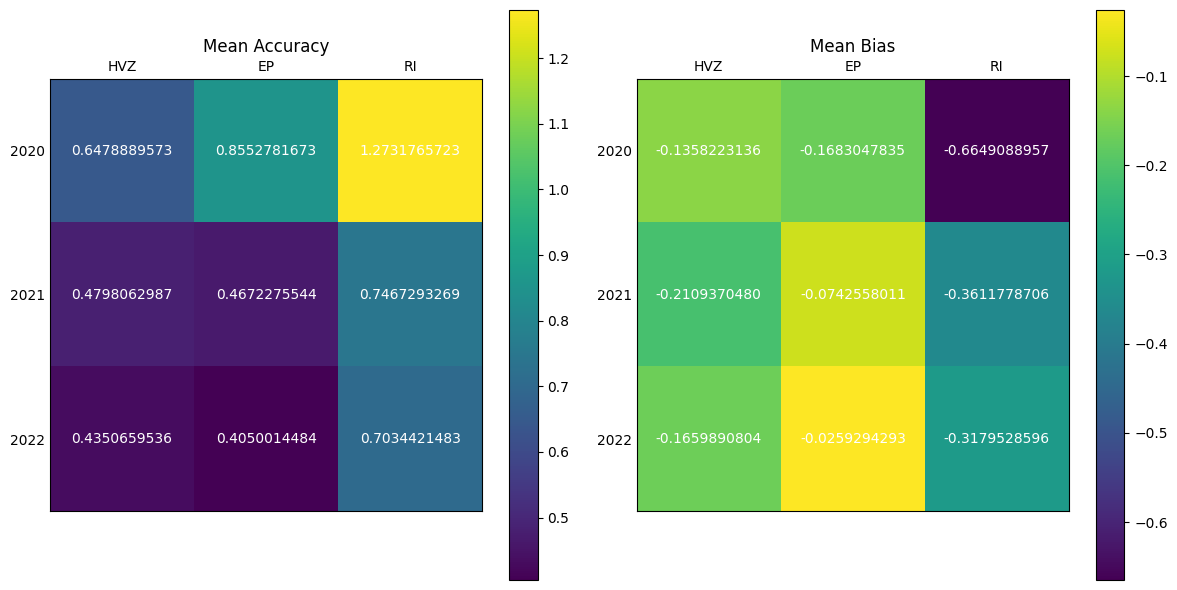

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Your DataFrame and calculations setup remains the same.
df = pd.DataFrame({
    'model1_accuracy': hvz_df_2020['accuracy'],
    'model1_bias': hvz_df_2020['bias'],
    'model2_accuracy': hvz_df_2021['accuracy'],
    'model2_bias': hvz_df_2021['bias'],
    'model3_accuracy': hvz_df_2022['accuracy'],
    'model3_bias': hvz_df_2022['bias'],
    'model4_accuracy': ep_df_2020['accuracy'],
    'model4_bias': ep_df_2020['bias'],
    'model5_accuracy': ep_df_2021['accuracy'],
    'model5_bias': ep_df_2021['bias'],
    'model6_accuracy': ep_df_2022['accuracy'],
    'model6_bias': ep_df_2022['bias'],
    'model7_accuracy': ri_df_2020['accuracy'],
    'model7_bias': ri_df_2020['bias'],
    'model8_accuracy': ri_df_2021['accuracy'],
    'model8_bias': ri_df_2021['bias'],
    'model9_accuracy': ri_df_2022['accuracy'],
    'model9_bias': ri_df_2022['bias']
})

mean_accuracies = [df[f'model{i}_accuracy'].mean() for i in range(1, 10)]
mean_biases = [df[f'model{i}_bias'].mean() for i in range(1, 10)]

# Reshape the means into 3x3 grids
accuracy_grid = np.array(mean_accuracies).reshape(3, 3)
bias_grid = np.array(mean_biases).reshape(3, 3)

# Function to plot a 3x3 grid with labeled axes
def plot_grid(grid, title, ax, row_labels, col_labels):
    cax = ax.matshow(grid, cmap='viridis')
    plt.colorbar(cax, ax=ax)
    ax.set_title(title)
    ax.set_xticks(range(len(col_labels)))
    ax.set_xticklabels(col_labels)
    ax.set_yticks(range(len(row_labels)))
    ax.set_yticklabels(row_labels)
    ax.tick_params(axis="both", which="both", length=0)  # Remove tick marks for cleaner design
    for (i, j), val in np.ndenumerate(grid):
        ax.text(j, i, f'{val:.10f}', ha='center', va='center', color='white')

# Labels for the axes
categories = ['HVZ', 'EP', 'RI']
years = ['2020', '2021', '2022']

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot accuracy and bias grids
plot_grid(accuracy_grid, 'Mean Accuracy', axes[0], years, categories)
plot_grid(bias_grid, 'Mean Bias', axes[1], years, categories)

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
# Data as provided in the user's message
data = {
    'Year': ['2020', '2021', '2022'],
    'HVZ': [0.8285909730757948, 0.7423154519816957, 0.7155062728757997],
    'EP': [0.15440273450216724, 0.09733224470831359, 0.0762658984354283],
    'RI': [0.33519265081956306, 0.2790404975171158, 0.26735806177502897]
}

# Creating a DataFrame
df = pd.DataFrame(data)
# Display the DataFrame
df

,Year,HVZ,EP,RI
0,2020,0.828591,0.154403,0.335193
1,2021,0.742315,0.097332,0.279040
2,2022,0.715506,0.076266,0.267358


# Part 2

In [ ]:
newdf = filtered_df.copy()

In [ ]:
# Calculate additional financial ratios and metrics
newdf['Operating_Margin'] = (newdf['ib'] - newdf['dp']) / newdf['at']
newdf['Debt_to_Asset'] = newdf['lt'] / newdf['at']
newdf['Interest_Coverage'] = newdf['ib'] / newdf['dltt'].replace(0, np.nan)  # Avoid division by zero
newdf['earning'] = newdf['ib'] - newdf['spi']

In [ ]:
# Convert all columns to numeric where possible, coercing errors to NaN
newdf = newdf.apply(pd.to_numeric, errors='coerce')

In [ ]:
# Replace inf and -inf with NaN, then fill NaN with the mean of each column or another suitable value
newdf.replace([np.inf, -np.inf], np.nan, inplace=True)
newdf.fillna(newdf.mean(), inplace=True)

In [ ]:
# Define features and target variable
feature_columns = ['act', 'lct', 'che', 'dlc', 'dp', 'at', 'dvc', 'txp', 'csho', 'ceq', 'ivao', 'lt', 'dltt', 'ivst', 'pstk',]

In [ ]:
X = newdf[feature_columns]
y = newdf['earning']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Lasso

In [ ]:
# Fit the Lasso model with cross-validation to find the best alpha
lasso = LassoCV(cv=5, random_state=42).fit(X_train, y_train)
# Print the coefficients from the Lasso model
print("Lasso coefficients:", lasso.coef_)
# Identify features with non-zero weights
selected_features = X.columns[(lasso.coef_ != 0)]
print("Selected features:", selected_features)

Lasso coefficients: [ 186.30139532   90.31288458   63.91331198 -159.81462719 -425.6771244
    0.          534.06855862   79.0063626    -0.          590.93010757
  162.8548952     0.           38.40464444  161.66752372    2.49064949]
Selected features: Index(['act', 'lct', 'che', 'dlc', 'dp', 'dvc', 'txp', 'ceq', 'ivao', 'dltt',
       'ivst', 'pstk'],
      dtype='object')


In [ ]:
# Coefficients from Lasso
coefficients = [186.30139532, 90.31288458, 63.91331198, -159.81462719, -425.6771244,
                0., 534.06855862, 79.0063626, -0., 590.93010757, 162.8548952, 0.,
                38.40464444, 161.66752372, 2.49064949, -0., 0., 0.]
features = ['act', 'sic','lct', 'che', 'dlc', 'dp', 'dvc', 'txp', 'ceq', 'ivao', 'dltt',
            'ivst', 'pstk']

filtered_coefficients = [coefficients[i] for i, f in enumerate(features) if f in features]

feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': filtered_coefficients
})

feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
top_features = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

# Display the top 5 features
print(top_features[['Feature', 'Coefficient']].head(5))


   Feature  Coefficient
9     ivao   590.930108
6      dvc   534.068559
4      dlc  -425.677124
0      act   186.301395
10    dltt   162.854895


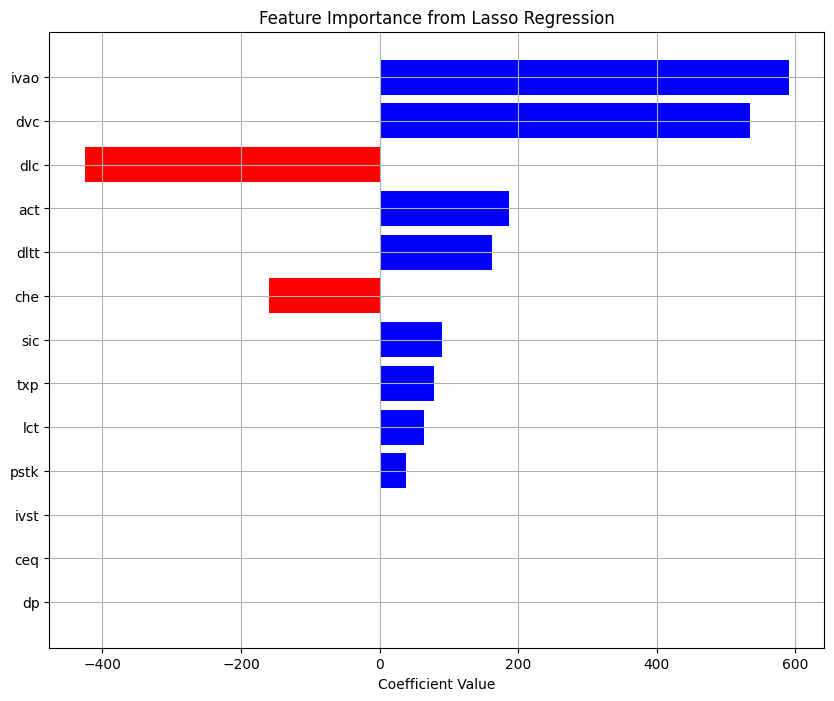

In [ ]:
feature_importance_sorted = feature_importance.sort_values(by='Abs_Coefficient', ascending=True)
# Plotting
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_sorted['Feature'], feature_importance_sorted['Coefficient'], color=(feature_importance_sorted['Coefficient'] > 0).map({True: 'b', False: 'r'}))
plt.xlabel('Coefficient Value')
plt.title('Feature Importance from Lasso Regression')
plt.grid(True)

## Model with New Feature

In [ ]:
def ep2(filtered_df,step):
    new_filtered_df = filtered_df.copy()
    new_filtered_df.sort_values(by=['gvkey', 'fyear'], inplace=True)

    new_filtered_df['earning'] = new_filtered_df['ib'] - new_filtered_df['spi']
    new_filtered_df['earnings_in_years_tau_num'] = new_filtered_df.groupby('gvkey')['earning'].shift(-(step))
    new_filtered_df = new_filtered_df[(new_filtered_df['csho'] != 0)]
    new_filtered_df['earnings_in_years_tau'] = new_filtered_df['earnings_in_years_tau_num'] / new_filtered_df['csho']
    new_filtered_df['NegE'] = np.where(new_filtered_df['earning'] < 0, 1, 0)
    new_filtered_df['NegE_earnings_in_years_t_interaction'] = new_filtered_df['NegE'] * new_filtered_df['earning']
    # add all new features in this function
    new_filtered_df['act'] = new_filtered_df['act']

    new_filtered_df['txp'] = new_filtered_df['txp']
    new_filtered_df['dp'] = new_filtered_df['dp']
    new_filtered_df['industry_freq'] = new_filtered_df['industry_freq']

    new_filtered_df.dropna(subset=['earning','NegE','NegE_earnings_in_years_t_interaction','earnings_in_years_tau'], inplace = True)

    return new_filtered_df

add all new features in this function, and then run the ep_model function directly, just like q1. if there are no changes in model evaluation, there is no need to change ep_model function

In [ ]:
def ep_model(data,step):

    temp_df = ep2(data,step)

    train_df = temp_df[(temp_df['fyear'] >= 2009) & (temp_df['fyear'] <= 2019)].copy()
    test_df = temp_df[(temp_df['fyear'] >= 2019) & (temp_df['fyear'] <= 2022)].copy()

    # varlist = ['earning','NegE','NegE_earnings_in_years_t_interaction','earnings_in_years_tau']
    varlist = ['earning','NegE','NegE_earnings_in_years_t_interaction','earnings_in_years_tau', 'act','txp','dp','industry_freq']
    ep_winsorized_df = windsorize_fun(train_df,varlist)

    coeff, adjusted_r_squared = regress_with_intercept(ep_winsorized_df, 'earnings_in_years_tau', ['earning','NegE','NegE_earnings_in_years_t_interaction',
                                    'act','txp','dp','industry_freq']) # add new feature here
    df_final = pd.DataFrame([coeff])
    df_return = merging_data_coeff(test_df,df_final)

    coeff_model = ['earning_coeff','NegE_coeff','NegE_earnings_in_years_t_interaction_coeff'
                  ,'act_coeff','txp_coeff','dp_coeff']
    values = ['earning','NegE','NegE_earnings_in_years_t_interaction']
    intercept_col = 'intercept_coeff'

    model_results = test_result(df_return,values,coeff_model,intercept_col)
    print('adjust_r_squared is: ', adjusted_r_squared)
    return model_results

In [ ]:
print('ep_df_2020')
ep_df_2020 = ep_model(filtered_df,1)
print('ep_df_2021')
ep_df_2021 = ep_model(filtered_df,2)
print('ep_df_2022')
ep_df_2022 = ep_model(filtered_df,3)

ep_df_2020
                              OLS Regression Results                             
Dep. Variable:     earnings_in_years_tau   R-squared:                       0.162
Model:                               OLS   Adj. R-squared:                  0.162
Method:                    Least Squares   F-statistic:                     1691.
Date:                   Thu, 25 Apr 2024   Prob (F-statistic):               0.00
Time:                           15:39:11   Log-Likelihood:            -1.6776e+05
No. Observations:                  61070   AIC:                         3.355e+05
Df Residuals:                      61062   BIC:                         3.356e+05
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

In [ ]:
ep_df_2020 = pd.merge(ep_df_2020, share_df, on="tic", how="left")
ep_df_2020 = ep_df_2020[ep_df_2020['fyear'] == 2019]
ep_df_2020.head()

,fyear,gvkey,tic,cik,act,lct,che,dlc,dp,at,...,NegE_coeff,NegE_earnings_in_years_t_interaction_coeff,act_coeff,txp_coeff,dp_coeff,industry_freq_coeff,intercept_coeff,expected_earnings_in_years_tau,cshom,prccm
0,2019,1004,AIR,1750.0,1438.700,383.100,424.700,13.700,43.700,2079.000,...,-2.345125,0.003155,0.000016,0.000147,-0.000185,-5.29865,1.756412,1.842879,3.506700e+07,36.7900
3,2019,1019,AFAP,2668.0,23.727,16.881,1.865,1.833,1.981,33.355,...,-2.345125,0.003155,0.000016,0.000147,-0.000185,-5.29865,1.756412,1.758575,1.930000e+05,199.0000
4,2019,1050,CECO,3197.0,179.498,115.188,36.958,5.626,10.609,408.637,...,-2.345125,0.003155,0.000016,0.000147,-0.000185,-5.29865,1.756412,1.775808,3.505200e+07,9.5900
7,2019,1078,ABT,1800.0,15667.000,10863.000,4140.000,1683.000,3014.000,67887.000,...,-2.345125,0.003155,0.000016,0.000147,-0.000185,-5.29865,1.756412,5.955952,1.764181e+09,84.1000
10,2019,1084,WDDD,1961.0,1.571,3.219,1.571,0.773,0.000,1.774,...,-2.345125,0.003155,0.000016,0.000147,-0.000185,-5.29865,1.756412,-0.593819,5.681500e+07,0.2801


In [ ]:
ep_df_2020.shape

(5647, 41)

# Part 3

In [ ]:
# analyst forecast
ibes_df = pd.read_csv('/content/drive/MyDrive/RSM8224 Accounting/FINAL Project/ibes_df.csv')
ibes_df.head()

,datadate,statpers,actual,medest,ticker,gvkey
0,2014-12-31,2014-04-17,1.21,0.51,0000,192458.0
1,2014-12-31,2014-05-15,1.21,0.58,0000,192458.0
2,2014-12-31,2014-06-19,1.21,0.58,0000,192458.0
3,2014-12-31,2014-07-17,1.21,0.58,0000,192458.0
4,2014-12-31,2014-08-14,1.21,1.17,0000,192458.0


In [ ]:
# Convert the 'datedate' column to datetime
ibes_df['datadate'] = pd.to_datetime(ibes_df['datadate'])

# Filter for rows where 'datedate' is in the year 2020
ibes_df_2020 = ibes_df[ibes_df['datadate'].dt.year == 2020]

# Sort by 'statpers' to make sure we keep the latest forecast per ticker
ibes_df_2020 = ibes_df_2020.sort_values(by='statpers', ascending=False)

# Drop duplicates based on 'ticker', keeping the latest 'statpers' for each 'ticker'
ibes_df_2020 = ibes_df_2020.drop_duplicates(subset='ticker')

In [ ]:
ibes_df_2020.head()

,datadate,statpers,actual,medest,ticker,gvkey
1532068,2020-12-31,2022-09-15,NaN,-0.03,OIBRC,NaN
1348308,2020-12-31,2022-08-18,NaN,-4.50,MKD,NaN
1074996,2020-12-31,2022-07-14,-0.25,-0.17,ILPM,NaN
1195819,2020-12-31,2022-03-17,-2.44,-0.04,KTOV,NaN
1784979,2020-12-31,2022-01-20,NaN,-0.88,RSTS,180905.0


In [ ]:
print(ibes_df.columns)

Index(['datadate', 'statpers', 'actual', 'medest', 'ticker', 'gvkey'], dtype='object')


In [ ]:
selected_ten = ep_df_2020.copy()

In [ ]:
# Selected ten companies
tickers_to_keep = ['PAGS', 'ETSY', 'MRNA', 'PTON', 'AMD', 'NVDA', 'Z', 'TTD', 'F', 'FSLR']
ten_df = selected_ten[selected_ten['tic'].isin(tickers_to_keep)]

In [ ]:
ten_df

,fyear,gvkey,tic,cik,act,lct,che,dlc,dp,at,...,NegE_coeff,NegE_earnings_in_years_t_interaction_coeff,act_coeff,txp_coeff,dp_coeff,industry_freq_coeff,intercept_coeff,expected_earnings_in_years_tau,cshom,prccm
25,2019,1161,AMD,2488.0,4597.000,2359.000,1507.000,43.000,142.000,6028.000,...,-2.336382,0.003138,0.000021,-0.000117,-0.000192,-5.317298,1.744769,2.283924,1.081601e+09,30.37
659,2019,4839,F,37996.0,114047.000,98132.000,34651.000,54313.000,9689.000,258537.000,...,-2.336382,0.003138,0.000021,-0.000117,-0.000192,-5.317298,1.744769,2.714025,3.918694e+09,10.23
4277,2019,23238,ETSY,1370637.0,921.038,188.528,817.252,12.409,48.031,1542.352,...,-2.336382,0.003138,0.000021,-0.000117,-0.000192,-5.317298,1.744769,1.846496,1.201840e+08,61.37
5413,2019,27885,TTD,1671933.0,1449.221,930.373,254.988,14.577,20.400,1728.761,...,-2.336382,0.003138,0.000021,-0.000117,-0.000192,-5.317298,1.744769,1.855166,3.851000e+07,227.78
6697,2019,32884,PAGS,1712807.0,3370.557,1466.070,685.044,0.000,31.930,3627.757,...,-2.336382,0.003138,0.000021,-0.000117,-0.000192,-5.317298,1.744769,2.091023,1.622280e+08,38.97
7326,2019,34410,MRNA,1682852.0,1128.804,143.115,1104.032,3.584,31.021,1589.422,...,-2.336382,0.003138,0.000021,-0.000117,-0.000192,-5.317298,1.744769,-2.728752,3.290110e+08,14.64
12060,2019,117768,NVDA,1045810.0,13690.000,1784.000,10897.000,91.000,381.000,17315.000,...,-2.336382,0.003138,0.000021,-0.000117,-0.000192,-5.317298,1.744769,4.609732,6.090000e+08,164.23
14190,2019,175404,FSLR,1274494.0,3599.834,1318.208,2177.944,28.612,205.300,7515.689,...,-2.336382,0.003138,0.000021,-0.000117,-0.000192,-5.317298,1.744769,1.997598,1.053530e+08,65.68
15818,2019,187039,Z,1617640.0,3510.154,920.517,2511.898,749.180,86.837,6131.973,...,-2.336382,0.003138,0.000021,-0.000117,-0.000192,-5.317298,1.744769,-1.761632,1.406330e+08,46.39


### Comparison between Predicted 2020 EPS and Actual 2020 EPS

In [ ]:
ten_df = bias(ten_df)

In [ ]:
ten_df = accuracy(ten_df)

In [ ]:
selected_columns = ['gvkey','tic','earnings_in_years_tau','expected_earnings_in_years_tau','bias','accuracy']

selected_df = ten_df[selected_columns]

In [ ]:
selected_df

,gvkey,tic,earnings_in_years_tau,expected_earnings_in_years_tau,bias,accuracy
25,1161,AMD,2.186325,2.283924,-0.000003,0.000003
659,4839,F,-1.121583,2.714025,-0.000096,0.000096
4277,23238,ETSY,3.108802,1.846496,0.000171,0.000171
5413,27885,TTD,5.328459,1.855166,0.000396,0.000396
6697,32884,PAGS,0.748230,2.091023,-0.000212,0.000212
7326,34410,MRNA,-2.219857,-2.728752,0.000106,0.000106
12060,117768,NVDA,7.514706,4.609732,0.000029,0.000029
14190,175404,FSLR,4.142808,1.997598,0.000310,0.000310
15818,187039,Z,-0.414046,-1.761632,0.000207,0.000207


### Comparison between Analyst 2020 EPS and Predicted 2020 EPS

In [ ]:
# merge selected_df by gvkey with ibes_df_2020 by ticker
merged_df = pd.merge(ten_df, ibes_df_2020, how='left', left_on='tic', right_on='ticker')

In [ ]:
merged_df

,fyear,gvkey_x,tic,cik,act,lct,che,dlc,dp,at,...,residual,market_value,bias,accuracy,datadate,statpers,actual,medest,ticker,gvkey_y
0,2019,1161,AMD,2488.0,4597.000,2359.000,1507.000,43.000,142.000,6028.000,...,-0.097599,32848.22237,-0.000003,0.000003,2020-12-31,2021-01-14,1.2900,1.23,AMD,1161.0
1,2019,4839,F,37996.0,114047.000,98132.000,34651.000,54313.000,9689.000,258537.000,...,-3.835609,40088.23962,-0.000096,0.000096,2020-12-31,2021-01-14,0.4100,-0.03,F,4839.0
2,2019,23238,ETSY,1370637.0,921.038,188.528,817.252,12.409,48.031,1542.352,...,1.262306,7375.69208,0.000171,0.000171,2020-12-31,2021-02-18,2.6900,2.13,ETSY,23238.0
3,2019,27885,TTD,1671933.0,1449.221,930.373,254.988,14.577,20.400,1728.761,...,3.473293,8771.80780,0.000396,0.000396,2020-12-31,2021-01-14,0.6850,0.49,TTD,27885.0
4,2019,32884,PAGS,1712807.0,3370.557,1466.070,685.044,0.000,31.930,3627.757,...,-1.342792,6322.02516,-0.000212,0.000212,2020-12-31,2021-02-18,4.3500,4.31,PAGS,32884.0
5,2019,34410,MRNA,1682852.0,1128.804,143.115,1104.032,3.584,31.021,1589.422,...,0.508895,4816.72104,0.000106,0.000106,2020-12-31,2021-02-18,-1.9600,-1.49,MRNA,34410.0
6,2019,117768,NVDA,1045810.0,13690.000,1784.000,10897.000,91.000,381.000,17315.000,...,2.904974,100016.07000,0.000029,0.000029,2020-01-31,2020-01-16,1.4475,1.39,NVDA,117768.0
7,2019,175404,FSLR,1274494.0,3599.834,1318.208,2177.944,28.612,205.300,7515.689,...,2.145210,6919.58504,0.000310,0.000310,2020-12-31,2021-02-18,3.7300,3.95,FSLR,175404.0
8,2019,187039,Z,1617640.0,3510.154,920.517,2511.898,749.180,86.837,6131.973,...,1.347586,6523.96487,0.000207,0.000207,2020-01-31,2020-02-20,4.9300,4.92,Z,11584.0


In [ ]:
def bias_new(data):
    data['residual'] = data['actual'] - data['expected_earnings_in_years_tau']
    data['market_value'] = data['cshom'] * data['prccm']/1000000
    data.dropna(subset=['market_value'], inplace = True)
    data = data[data['market_value'] != 0]
    data['bias_analyst'] = data['residual'] / data['market_value']
    return data

In [ ]:
def accuracy_new(data):
    data['accuracy_analyst'] = abs(data['bias_analyst'])
    return data

In [ ]:
merged_df = bias_new(merged_df)

In [ ]:
merged_df = accuracy_new(merged_df)

In [ ]:
selected_columns_new = ['tic','earnings_in_years_tau','expected_earnings_in_years_tau','bias','accuracy','actual','medest','bias_analyst','accuracy_analyst']

In [ ]:
selected_new_df = merged_df[selected_columns_new]

In [ ]:
selected_new_df

,tic,earnings_in_years_tau,expected_earnings_in_years_tau,bias,accuracy,actual,medest,bias_analyst,accuracy_analyst
0,AMD,2.186325,2.283924,-0.000003,0.000003,1.2900,1.23,-0.000030,0.000030
1,F,-1.121583,2.714025,-0.000096,0.000096,0.4100,-0.03,-0.000057,0.000057
2,ETSY,3.108802,1.846496,0.000171,0.000171,2.6900,2.13,0.000114,0.000114
3,TTD,5.328459,1.855166,0.000396,0.000396,0.6850,0.49,-0.000133,0.000133
4,PAGS,0.748230,2.091023,-0.000212,0.000212,4.3500,4.31,0.000357,0.000357
5,MRNA,-2.219857,-2.728752,0.000106,0.000106,-1.9600,-1.49,0.000160,0.000160
6,NVDA,7.514706,4.609732,0.000029,0.000029,1.4475,1.39,-0.000032,0.000032
7,FSLR,4.142808,1.997598,0.000310,0.000310,3.7300,3.95,0.000250,0.000250
8,Z,-0.414046,-1.761632,0.000207,0.000207,4.9300,4.92,0.001026,0.001026


# Part 4

In [ ]:
df_23 = ep_df_2022.copy()

In [ ]:
df_23.head()

,fyear,gvkey,tic,cik,act,lct,che,dlc,dp,at,...,NegE_earnings_in_years_t_interaction,earning_coeff,NegE_coeff,NegE_earnings_in_years_t_interaction_coeff,act_coeff,txp_coeff,dp_coeff,industry_freq_coeff,intercept_coeff,expected_earnings_in_years_tau
10,2019,1004,AIR,1750.0,1438.700,383.100,424.700,13.700,43.700,2079.000,...,0.000,0.000964,-3.272983,-0.001307,0.000033,-0.000677,-0.000155,-10.336565,2.158497,2.243365
38,2019,1050,CECO,3197.0,179.498,115.188,36.958,5.626,10.609,408.637,...,0.000,0.000964,-3.272983,-0.001307,0.000033,-0.000677,-0.000155,-10.336565,2.158497,2.177534
76,2019,1078,ABT,1800.0,15667.000,10863.000,4140.000,1683.000,3014.000,67887.000,...,0.000,0.000964,-3.272983,-0.001307,0.000033,-0.000677,-0.000155,-10.336565,2.158497,6.280352
92,2019,1084,WDDD,1961.0,1.571,3.219,1.571,0.773,0.000,1.774,...,-1.234,0.000964,-3.272983,-0.001307,0.000033,-0.000677,-0.000155,-10.336565,2.158497,-1.114064
116,2019,1096,MRCBF,NaN,222.852,1160.841,123.168,919.871,36.152,11703.084,...,0.000,0.000964,-3.272983,-0.001307,0.000033,-0.000677,-0.000155,-10.336565,2.158497,2.339323


In [ ]:
df_23['growth_rate'] = ((df_23['expected_earnings_in_years_tau'] - df_23['expected_earnings_in_years_tau']) / df_23['expected_earnings_in_years_tau']) * 100

In [ ]:
def ep4(filtered_df,step):
    new_filtered_df = filtered_df.copy()
    new_filtered_df.sort_values(by=['gvkey', 'fyear'], inplace=True)

    new_filtered_df['earning'] = new_filtered_df['ib'] - new_filtered_df['spi']
    new_filtered_df['NegE'] = np.where(new_filtered_df['earning'] < 0, 1, 0)
    new_filtered_df['NegE_earnings_in_years_t_interaction'] = new_filtered_df['NegE'] * new_filtered_df['earning']
   # new_filtered_df.dropna(subset=['earning','NegE','NegE_earnings_in_years_t_interaction'], inplace = True)

    # add all new features in this function
    new_filtered_df['act'] = new_filtered_df['act']

    new_filtered_df['txp'] = new_filtered_df['txp']
    new_filtered_df['dp'] = new_filtered_df['dp']
    new_filtered_df['industry_freq'] = new_filtered_df['industry_freq']

    new_filtered_df.dropna(subset=['earning','NegE','NegE_earnings_in_years_t_interaction','act', 'txp', 'dp', 'industry_freq'], inplace = True)

    return new_filtered_df

In [ ]:
actual_22 = ep4(actual_22,0)

In [ ]:
actual_22.head()

,fyear,gvkey,tic,cik,act,lct,che,dlc,dp,at,...,term_NegE,term_E,term_NegE_E,expected_eps_2023,term_act,term_txp,term_dp,term_industry_freq,eps_22,growth_rate
41,2022,1050,CECO,3197.0,240.658,146.700,46.585,7.452,10.614,504.721,...,-0.000000,0.020863,0.000000,1.628769,0.005042,-0.000376,-0.002038,-0.139490,0.595370,173.572794
79,2022,1078,ABT,1800.0,25224.000,15489.000,10170.000,2481.000,3267.000,74438.000,...,-0.000000,7.821317,0.000000,9.224291,0.528457,-0.040204,-0.627443,-0.202606,4.415941,108.886194
221,2022,1186,AEM,2809.0,2180.059,946.422,668.521,136.466,1121.059,23494.808,...,-0.000000,0.959634,0.000000,2.133266,0.045674,-0.000491,-0.215305,-0.401015,2.062719,3.420118
408,2022,1397,ABLT,4611.0,75.295,50.533,1.297,18.536,3.505,124.413,...,-2.336382,-0.005897,-0.018159,-0.639791,0.001577,-0.000000,-0.000673,-0.025027,-180.812500,99.646158
521,2022,1559,AMS,744825.0,18.723,5.175,12.453,1.554,4.783,43.956,...,-0.000000,0.001353,0.000000,1.683274,0.000392,-0.000030,-0.000919,-0.062292,0.214748,683.837991


In [ ]:
# actual_22 = ep2(actual_22,0)

In [ ]:
ep_df_2020.head()

,fyear,gvkey,tic,cik,act,lct,che,dlc,dp,at,...,NegE_coeff,NegE_earnings_in_years_t_interaction_coeff,act_coeff,txp_coeff,dp_coeff,industry_freq_coeff,intercept_coeff,expected_earnings_in_years_tau,cshom,prccm
0,2019,1004,AIR,1750.0,1438.700,383.100,424.700,13.700,43.700,2079.000,...,-2.336382,0.003138,0.000021,-0.000117,-0.000192,-5.317298,1.744769,1.834458,3.506700e+07,36.7900
3,2019,1019,AFAP,2668.0,23.727,16.881,1.865,1.833,1.981,33.355,...,-2.336382,0.003138,0.000021,-0.000117,-0.000192,-5.317298,1.744769,1.747012,1.930000e+05,199.0000
4,2019,1050,CECO,3197.0,179.498,115.188,36.958,5.626,10.609,408.637,...,-2.336382,0.003138,0.000021,-0.000117,-0.000192,-5.317298,1.744769,1.764887,3.505200e+07,9.5900
7,2019,1078,ABT,1800.0,15667.000,10863.000,4140.000,1683.000,3014.000,67887.000,...,-2.336382,0.003138,0.000021,-0.000117,-0.000192,-5.317298,1.744769,6.100817,1.764181e+09,84.1000
10,2019,1084,WDDD,1961.0,1.571,3.219,1.571,0.773,0.000,1.774,...,-2.336382,0.003138,0.000021,-0.000117,-0.000192,-5.317298,1.744769,-0.596743,5.681500e+07,0.2801


In [ ]:
print(ep_df_2020.columns)

Index(['fyear', 'gvkey', 'tic', 'cik', 'act', 'lct', 'che', 'dlc', 'dp', 'at',
       'ib', 'spi', 'dvc', 'txp', 'csho', 'ceq', 'ivao', 'lt', 'dltt', 'ivst',
       'pstk', 'conm', 'sic', 'industry', 'industry_freq', 'earning',
       'earnings_in_years_tau_num', 'earnings_in_years_tau', 'NegE',
       'NegE_earnings_in_years_t_interaction', 'earning_coeff', 'NegE_coeff',
       'NegE_earnings_in_years_t_interaction_coeff', 'act_coeff', 'txp_coeff',
       'dp_coeff', 'industry_freq_coeff', 'intercept_coeff',
       'expected_earnings_in_years_tau', 'cshom', 'prccm'],
      dtype='object')


In [ ]:
print(actual_22.columns)

Index(['fyear', 'gvkey', 'tic', 'cik', 'act', 'lct', 'che', 'dlc', 'dp', 'at',
       'ib', 'spi', 'dvc', 'txp', 'csho', 'ceq', 'ivao', 'lt', 'dltt', 'ivst',
       'pstk', 'conm', 'sic', 'industry', 'industry_freq', 'earning', 'NegE',
       'NegE_earnings_in_years_t_interaction', 'earnings_in_years_tau_num',
       'earnings_in_years_tau', 'term_NegE', 'term_E', 'term_NegE_E',
       'expected_eps_2023', 'term_act', 'term_txp', 'term_dp',
       'term_industry_freq', 'eps_22', 'growth_rate'],
      dtype='object')


In [ ]:
actual_22.isna().sum()

fyear                                     0
gvkey                                     0
tic                                       2
cik                                     112
act                                       0
lct                                       1
che                                       1
dlc                                       1
dp                                        0
at                                        0
ib                                        0
spi                                       0
dvc                                       8
txp                                       0
csho                                      0
ceq                                       4
ivao                                     82
lt                                        3
dltt                                      2
ivst                                     23
pstk                                      4
conm                                      0
sic                             

In [ ]:
beta_0 = ep_df_2020['intercept_coeff'].mean()
beta_1 = ep_df_2020['NegE_coeff'].mean()
beta_2 = ep_df_2020['earning_coeff'].mean()
beta_3 = ep_df_2020['NegE_earnings_in_years_t_interaction_coeff'].mean()
beta_4 = ep_df_2020['act_coeff'].mean()
beta_5 = ep_df_2020['txp_coeff'].mean()
beta_6 = ep_df_2020['dp_coeff'].mean()
beta_7 = ep_df_2020['industry_freq_coeff'].mean()

actual_22['term_NegE'] = actual_22['NegE'] * beta_1
actual_22['term_E'] = actual_22['earning'] * beta_2
actual_22['term_NegE_E'] = actual_22['NegE_earnings_in_years_t_interaction'] * beta_3
actual_22['term_act'] = actual_22['act'] * beta_4
actual_22['term_txp'] = actual_22['txp'] * beta_5
actual_22['term_dp'] = actual_22['dp'] * beta_6
actual_22['term_industry_freq'] = actual_22['industry_freq'] * beta_7

actual_22['expected_eps_2023'] = actual_22['term_NegE'] + actual_22['term_E'] + actual_22['term_NegE_E'] + actual_22['term_act'] + actual_22['term_txp'] + actual_22['term_dp'] + actual_22['term_industry_freq']
# actual_22['expected_eps_2023'] = beta_0 + actual_22['term_NegE'] + actual_22['term_E'] + actual_22['term_NegE_E'] + actual_22['term_act'] + actual_22['term_txp'] + actual_22['term_dp'] #+ actual_22['term_industry_freq']

In [ ]:
beta_0

1.7564124810419242

In [ ]:
actual_22['eps_22'] = actual_22['earning']/actual_22['csho']

In [ ]:
actual_22[['gvkey','tic','earning','csho','eps_22','expected_eps_2023']].head()

,gvkey,tic,earning,csho,eps_22,expected_eps_2023
41,1050,CECO,20.470,34.382,0.595370,-0.116423
79,1078,ABT,7674.000,1737.795,4.415941,7.198314
221,1186,AEM,941.559,456.465,2.062719,0.354218
408,1397,ABLT,-5.786,0.032,-180.812500,-2.393416
521,1559,AMS,1.328,6.184,0.214748,-0.061310


In [ ]:
actual_22 = actual_22[actual_22['expected_eps_2023'] >= actual_22['eps_22']]

In [ ]:
actual_22['growth_rate'] = abs((actual_22['expected_eps_2023']-actual_22['eps_22'])*100/actual_22['eps_22'])

In [ ]:
varlist = ['earning','NegE','NegE_earnings_in_years_t_interaction','earnings_in_years_tau', 'act','txp','dp','industry_freq', 'eps_22']
actual_22 = windsorize_fun(actual_22,varlist)

In [ ]:
actual_22[['gvkey','tic','earning','csho','eps_22','expected_eps_2023', 'growth_rate']].head()

,gvkey,tic,earning,csho,eps_22,expected_eps_2023,growth_rate
79,1078,ABT,7674.000,1737.795,4.415941,7.198314,63.007482
408,1397,ABLT,-5.786,0.032,-180.812500,-2.393416,98.676299
684,1661,NBR,-354.858,9.415,-37.690706,-4.165262,88.948837
1037,1932,BTI,10006.694,2229.946,4.487415,10.148615,126.157236
1169,2055,GOLD,1603.000,1755.350,0.913208,0.981499,7.478099


In [ ]:
actual_22

,fyear,gvkey,tic,cik,act,lct,che,dlc,dp,at,...,term_NegE,term_E,term_NegE_E,expected_eps_2023,term_act,term_txp,term_dp,term_industry_freq,eps_22,growth_rate
79,2022,1078,ABT,1800.0,25224.000,15489.000,10170.000,2481.000,3267.000,74438.000,...,-0.000000,7.540305,0.000000,7.198314,0.415184,0.050373,-0.605653,-0.201895,4.415941,63.007482
408,2022,1397,ABLT,4611.0,75.295,50.533,1.297,18.536,3.505,124.413,...,-2.345125,-0.005685,-0.018256,-2.393416,0.001239,0.000000,-0.000650,-0.024939,-180.812500,98.676299
684,2022,1661,NBR,1163739.0,1000.623,596.390,452.315,6.784,665.072,4729.854,...,-2.345125,-0.348676,-1.119671,-4.165262,0.016470,0.004111,-0.123294,-0.249076,-37.690706,88.948837
1037,2022,1932,BTI,1303523.0,18566.304,21511.080,4849.722,5317.224,910.904,185007.575,...,-0.000000,9.832360,0.000000,10.148615,0.305599,0.185622,-0.168868,-0.006098,4.487415,126.157236
1169,2022,2055,GOLD,756894.0,8465.000,3120.000,5385.000,45.000,1927.000,45965.000,...,-0.000000,1.575073,0.000000,0.981499,0.139333,0.023938,-0.357237,-0.399608,0.913208,7.478099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135345,2022,324261,GMVDF,1760764.0,1.993,9.113,0.437,1.809,1.212,4.825,...,-2.345125,-0.013195,-0.042372,-2.462958,0.000033,0.000000,-0.000225,-0.062074,-8.794368,71.993917
135375,2022,325778,MYNA,1850453.0,32.456,46.179,10.942,17.415,6.782,85.842,...,-2.345125,-0.075873,-0.243643,-2.867260,0.000534,0.000000,-0.001257,-0.201895,-3.405575,15.806871
135532,2022,349994,CMND,1892500.0,0.778,2.638,NaN,NaN,0.113,1.128,...,-2.345125,-0.009247,-0.029694,-2.965372,0.000010,0.000000,-0.000021,-0.581295,-7.129545,58.407272
135546,2022,351590,DTRUY,1890567.0,34596.255,22419.006,7553.870,8027.323,1963.278,68366.372,...,-0.000000,3.213376,0.000000,3.307016,0.569450,0.027153,-0.363962,-0.139001,1.986963,66.435669


In [ ]:
# Sort the DataFrame by 'growth_rate' in descending order to get the highest growth rates at the top
top_firms = actual_22.sort_values(by='growth_rate', ascending=False).head(10)
top_firms.head(10)

,fyear,gvkey,tic,cik,act,lct,che,dlc,dp,at,...,term_NegE,term_E,term_NegE_E,expected_eps_2023,term_act,term_txp,term_dp,term_industry_freq,eps_22,growth_rate
85360,2022,140756,SNPMF,1123658.0,57517.000,96762.149,21539.413,11937.215,7700.288,282527.468,...,-0.0,9.424227,0.0,9.026802,0.946723,0.100608,-1.427518,-0.017238,0.079997,11183.958835
132423,2022,201140,ABEV,1565025.0,7153.340,7668.550,2909.423,199.921,1045.061,26095.890,...,-0.0,2.525373,0.0,2.391446,0.117743,0.031074,-0.193739,-0.089006,0.163270,1364.720492
12434,2022,12141,MSFT,789019.0,57517.000,95082.000,104757.000,6037.000,7700.288,364840.000,...,-0.0,15.672123,0.0,14.959278,0.946723,0.272278,-1.427518,-0.504328,2.136924,600.037916
132950,2022,222111,PBR,1119639.0,31250.000,31380.000,10769.000,8668.000,7700.288,187191.000,...,-0.0,15.672123,0.0,15.004908,0.514371,0.272278,-1.427518,-0.026346,2.445531,513.564418
38006,2022,25648,RHHBY,889131.0,36572.000,29459.000,10563.000,4609.000,3944.000,95335.000,...,-0.0,15.672123,0.0,15.233918,0.601971,0.272278,-0.731158,-0.581295,2.494743,510.640866
132856,2022,218399,ALSMY,1062066.0,15808.415,19167.608,897.378,586.664,479.109,34109.064,...,-0.0,0.202823,0.0,0.328665,0.260205,0.042759,-0.088820,-0.088302,0.054256,505.766554
33992,2022,23671,NOK,924613.0,21659.130,13652.113,9134.540,440.322,1218.366,45894.998,...,-0.0,4.775959,0.0,4.704032,0.356507,0.029037,-0.225867,-0.231603,0.869989,440.700495
8628,2022,8530,PFE,78003.0,51259.000,42138.000,22732.000,3565.000,5064.000,197205.000,...,-0.0,15.672123,0.0,15.228822,0.843717,0.233066,-0.938789,-0.581295,2.840100,436.207292
74172,2022,102450,NTDOY,852937.0,17410.531,4013.013,14137.219,0.339,83.047,21470.866,...,-0.0,3.198709,0.0,3.539702,0.286575,0.091195,-0.015396,-0.021382,0.699051,406.357906
132451,2022,201395,TSM,1046179.0,57517.000,32113.859,50832.402,713.438,7700.288,161599.250,...,-0.0,15.672123,0.0,15.232002,0.946723,0.272278,-1.427518,-0.231603,3.075543,395.262209


In [ ]:
top_firms[['tic', 'gvkey','earning','NegE','NegE_earnings_in_years_t_interaction','earnings_in_years_tau', 'act','txp','dp','industry_freq', 'eps_22']]

,tic,gvkey,earning,NegE,NegE_earnings_in_years_t_interaction,earnings_in_years_tau,act,txp,dp,industry_freq,eps_22
85360,SNPMF,140756,9591.325,0,0.0,0.079997,57517.000,685.064,7700.288,0.003253,0.079997
132423,ABEV,201140,2570.150,0,0.0,0.163270,7153.340,211.592,1045.061,0.016798,0.163270
12434,MSFT,12141,15950.000,0,0.0,7.780414,57517.000,1854.000,7700.288,0.095180,2.136924
132950,PBR,222111,15950.000,0,0.0,5.600496,31250.000,1854.000,7700.288,0.004972,2.445531
38006,RHHBY,25648,15950.000,0,0.0,2.494743,36572.000,1854.000,3944.000,0.109706,2.494743
132856,ALSMY,218399,206.419,0,0.0,0.054256,15808.415,291.159,479.109,0.016665,0.054256
33992,NOK,23671,4860.640,0,0.0,0.869989,21659.130,197.717,1218.366,0.043710,0.869989
8628,PFE,8530,15950.000,0,0.0,6.282942,51259.000,1587.000,5064.000,0.109706,2.840100
74172,NTDOY,102450,3255.424,0,0.0,0.699051,17410.531,620.968,83.047,0.004035,0.699051
132451,TSM,201395,15950.000,0,0.0,6.237205,57517.000,1854.000,7700.288,0.043710,3.075543


In [ ]:
top_firms['sum'] = top_firms['term_NegE'] + top_firms['term_E'] + top_firms['term_NegE_E'] + top_firms['term_act'] + top_firms['term_txp'] + top_firms['term_dp']
top_firms[['term_NegE', 'term_E', 'term_NegE_E', 'term_act', 'term_txp', 'term_dp', 'sum']]

,term_NegE,term_E,term_NegE_E,term_act,term_txp,term_dp,sum
85360,-0.0,9.424227,0.0,0.946723,0.100608,-1.427518,9.044041
132423,-0.0,2.525373,0.0,0.117743,0.031074,-0.193739,2.480452
12434,-0.0,15.672123,0.0,0.946723,0.272278,-1.427518,15.463606
132950,-0.0,15.672123,0.0,0.514371,0.272278,-1.427518,15.031254
38006,-0.0,15.672123,0.0,0.601971,0.272278,-0.731158,15.815213
132856,-0.0,0.202823,0.0,0.260205,0.042759,-0.088820,0.416967
33992,-0.0,4.775959,0.0,0.356507,0.029037,-0.225867,4.935636
8628,-0.0,15.672123,0.0,0.843717,0.233066,-0.938789,15.810116
74172,-0.0,3.198709,0.0,0.286575,0.091195,-0.015396,3.561083
132451,-0.0,15.672123,0.0,0.946723,0.272278,-1.427518,15.463606


In [ ]:
print(top_firms['tic'])

85360     SNPMF
132423     ABEV
12434      MSFT
132950      PBR
38006     RHHBY
132856    ALSMY
33992       NOK
8628        PFE
74172     NTDOY
132451      TSM
Name: tic, dtype: object
